In [51]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup as bsoup
from thefuzz import fuzz

from typing import Any, List, Dict, Tuple, Optional

import constants, index_tools, data_tools, medical_code_tools

from utilities import *

if is_jupyter_notebook():
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Index

In [52]:
biobank_index_full = index_tools.load_index()

In [53]:
biobank_index_full = index_tools.add_udi_names_to_index(biobank_index_full)

In [65]:
missing_name_index = index_tools.get_indices_missing_names(biobank_index_full)
print("Still missing", len(biobank_index_full.loc[biobank_index_full["name"].isna()]), "names")

for i in range(4):
    biobank_index_full.loc[biobank_index_full["udi"] == f"20199-2.{i}", "name"] = f"antibiotic_codes_past_3_months_2.{i}"

biobank_index_full.loc[biobank_index_full["udi"] == "6671-2.0", "name"] = f"n_antibiotics_past_3_months"

Still missing 0 names


In [66]:
biobank_index_full.loc[biobank_index_full["udi"] == f"20199-2.3"]

,column,udi,count,type,description,data_code,name,counts,frequency
1762,1762,20199-2.3,2,Categorical (multiple),Antibiotic codes for last 3 months,744,antibiotic_codes_past_3_months_2.3,0,0.0


In [67]:
udi_map = index_tools.UDIMap(biobank_index_full)

# Load BioBank Data

In [68]:
correct_feature_typing = False
biobank_data_full = data_tools.load_biobank_data(constants.UK_BIOBANK_DATA_CSV_PATH, udi_map)
biobank_index_full = index_tools.add_biobank_info_to_index(biobank_index_full, biobank_data_full)

features = biobank_index_full.query("type == 'Continuous' or type == 'Integer'")["name"]
biobank_data_full = biobank_data_full.astype({feature: 'float' for feature in features})

display(biobank_data_full.head())

UK BioBank Data Loaded.
Size: 9999 rows x 2781 columns


,eid,verbal_interview_duration,verbal_interview_duration_1.0,verbal_interview_duration_2.0,sex,birth_year,bp_device,bp_device_1.0,bp_device_2.0,bp_manual_device_ID,...,operative_procedures_OPCS4_secondary_0.82,operative_procedures_OPCS4_secondary_0.83,operative_procedures_OPCS4_secondary_0.84,operative_procedures_OPCS4_secondary_0.85,important_unlabeled_34,inpatient_record_format,inpatient_record_format_0.1,inpatient_record_format_0.2,inpatient_record_format_0.3,inpatient_record_format_0.4
0,1000013,485.0,NaN,NaN,1,1962.0,002817,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,18,NaN,NaN,NaN,NaN
1,1000024,328.0,NaN,NaN,0,1941.0,001054,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,6,NaN,NaN,NaN,NaN
2,1000036,364.0,NaN,NaN,0,1955.0,003159,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,6,NaN,NaN,NaN,NaN
3,1000048,322.0,NaN,NaN,1,1941.0,003780,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,18,NaN,NaN,NaN,NaN
4,1000055,477.0,NaN,NaN,0,1947.0,003156,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,6,18,NaN,NaN,NaN


In [69]:
biobank_index_primary = biobank_index_full.copy(deep=True)
biobank_index_primary["primary_udi"] = biobank_index_primary["udi"].apply(lambda s: s.split("-")[0])
# biobank_index_primary = biobank_index_primary.drop_duplicates(["primary_udi"])

In [70]:
biobank_data_full[["illness_code", "illness_code_0.1", "treatment_code"]]

,illness_code,illness_code_0.1,treatment_code
0,1065,1465,1140884488
1,NaN,NaN,NaN
2,NaN,NaN,1140870164
3,1065,1637,1140860696
4,1075,1074,1140868226
...,...,...,...
9994,NaN,NaN,1140870200
9995,1074,1065,1140861138
9996,NaN,NaN,NaN
9997,1142,1505,1140871050


In [71]:
biobank_index_primary.query("primary_udi == '20002'")

,column,udi,count,type,description,data_code,name,counts,frequency,primary_udi
968,968,20002-0.0,375059,Categorical (multiple),"Non-cancer illness code, self-reported",6,illness_code,7471,0.747175,20002
969,969,20002-0.1,240978,Categorical (multiple),"Non-cancer illness code, self-reported",6,illness_code_0.1,4789,0.478948,20002
970,970,20002-0.2,142170,Categorical (multiple),"Non-cancer illness code, self-reported",6,illness_code_0.2,2773,0.277328,20002
971,971,20002-0.3,79358,Categorical (multiple),"Non-cancer illness code, self-reported",6,illness_code_0.3,1579,0.157916,20002
972,972,20002-0.4,43397,Categorical (multiple),"Non-cancer illness code, self-reported",6,illness_code_0.4,866,0.086609,20002
...,...,...,...,...,...,...,...,...,...,...
1065,1065,20002-2.29,12,Categorical (multiple),"Non-cancer illness code, self-reported",6,illness_code_2.29,1,0.000100,20002
1066,1066,20002-2.30,9,Categorical (multiple),"Non-cancer illness code, self-reported",6,illness_code_2.30,1,0.000100,20002
1067,1067,20002-2.31,7,Categorical (multiple),"Non-cancer illness code, self-reported",6,illness_code_2.31,1,0.000100,20002
1068,1068,20002-2.32,5,Categorical (multiple),"Non-cancer illness code, self-reported",6,illness_code_2.32,0,0.000000,20002


In [72]:
biobank_index_primary.query("name == 'illness_code'")

,column,udi,count,type,description,data_code,name,counts,frequency,primary_udi
968,968,20002-0.0,375059,Categorical (multiple),"Non-cancer illness code, self-reported",6,illness_code,7471,0.747175,20002


In [73]:
categorical_features = biobank_index_primary.query("type == 'Categorical (multiple)'")["name"].values
categorical_features

array(['household_n_people_related', 'household_n_people_related_0.1',
       'household_n_people_related_0.2', ...,
       'inpatient_record_format_0.2', 'inpatient_record_format_0.3',
       'inpatient_record_format_0.4'], dtype=object)

In [74]:
biobank_data_full["medications_HLD_HTN_diabetes"].describe()

count     4612
unique       6
top         -7
freq      3014
Name: medications_HLD_HTN_diabetes, dtype: object

In [75]:
biobank_index_primary.query("type == 'Curve'")

,column,udi,count,type,description,data_code,name,counts,frequency,primary_udi
1941,1941,22182-0.0,488288,Curve,HLA imputation values,None,HLA_imputation,9699,0.969997,22182
2226,2226,40010-0.0,17027,Curve,Description of cause of death,None,death_cause_curve,332,0.033203,40010


In [76]:
biobank_index_full.type.unique()

array(['Sequence', 'Integer', 'Categorical (single)', 'Text', 'Date',
       'Continuous', 'Categorical (multiple)', 'Time', 'Curve'],
      dtype=object)

# Clean + Reduce feature set

In [77]:
biobank_data = data_tools.clean_biobank_data(biobank_data_full)

# reduced_feature_set = data_tools.create_reduced_feature_set(biobank_data)


# biobank_index = biobank_index_full.loc[biobank_index_full["name"].isin(reduced_feature_set)].reset_index(drop=True)
biobank_data = biobank_data_full  #[reduced_feature_set]
biobank_index = biobank_index_full

# BioBank Code Download

In [78]:
medical_code_tools.download_biobank_code_data(code=198, overwrite=False)

code 198 files already exist.


In [79]:
biobank_index["data_code"].unique()

array([None, '9', '8', '10', '37', '100258', '170', '1965', '100286',
       '100291', '100294', '100298', '100300', '100301', '100347',
       '100348', '100370', '100373', '100377', '100387', '100388',
       '100391', '100393', '100394', '100397', '100398', '100400',
       '100401', '100402', '100416', '100417', '100349', '100484',
       '100508', '100539', '100540', '100603', '100389', '100418',
       '100351', '100353', '100369', '100267', '100355', '100356',
       '100357', '100358', '100359', '100360', '100352', '100617',
       '100259', '100478', '100479', '100499', '100500', '100292',
       '100299', '100385', '100502', '100538', '100605', '100622',
       '100610', '100626', '100628', '100629', '100498', '100361',
       '100625', '100630', '100688', '100689', '100685', '100692',
       '100669', '100683', '100691', '100673', '100674', '100668',
       '100690', '100672', '3', '6', '4', '13', '14', '1010', '89', '90',
       '100295', '100694', '7', '100695', '744', '50

In [80]:
medical_code_tools.download_all_biobank_codes(biobank_index, overwrite=False);

code 1 files already exist.
code 10 files already exist.
code 1001 files already exist.
code 1002 files already exist.
code 100258 files already exist.
code 100259 files already exist.
code 100264 files already exist.
code 100267 files already exist.
code 100286 files already exist.
code 100291 files already exist.
code 100292 files already exist.
code 100294 files already exist.
code 100295 files already exist.
code 100298 files already exist.
code 100299 files already exist.
code 100300 files already exist.
code 100301 files already exist.
code 100347 files already exist.
code 100348 files already exist.
code 100349 files already exist.
code 100351 files already exist.
code 100352 files already exist.
code 100353 files already exist.
code 100355 files already exist.
code 100356 files already exist.
code 100357 files already exist.
code 100358 files already exist.
code 100359 files already exist.
code 100360 files already exist.
code 100361 files already exist.
code 100369 files alrea

# BioBank Code Intersections

In [376]:
med_code_mapping = medical_code_tools.MedicalCodeMapping(biobank_index) 

In [377]:
med_code_mapping.build_tree("cancer_code")

cancer_code
├── breast cancer (1002)
├── ear/nose/throat cancer (-1)
│   ├── cancer of lip/mouth/pharynx/oral cavity (1004)
│   │   ├── gum cancer (1012)
│   │   ├── lip cancer (1010)
│   │   ├── mouth cancer (1077)
│   │   ├── oropharynx / oropharyngeal cancer (1079)
│   │   ├── salivary gland cancer (1005)
│   │   │   ├── other salivary gland cancer (1016)
│   │   │   └── parotid gland cancer (1015)
│   │   ├── tongue cancer (1011)
│   │   └── tonsil cancer (1078)
│   ├── nasal cavity cancer (1007)
│   └── sinus cancer (1009)
├── gastrointestinal cancer (-1)
│   ├── anal cancer (1021)
│   ├── gallbladder/bile duct cancer (1025)
│   ├── large bowel cancer/colorectal cancer (1020)
│   │   ├── colon cancer/sigmoid cancer (1022)
│   │   │   └── appendix cancer (1086)
│   │   └── rectal cancer (1023)
│   ├── liver/hepatocellular cancer (1024)
│   ├── oesophageal cancer (1017)
│   ├── pancreas cancer (1026)
│   │   └── malignant insulinoma (1088)
│   ├── small intestine/small bowel cancer 

In [378]:
med_code_mapping.decode(code_format="946", coded_value="-818")
med_code_mapping.decode(code_format="9", coded_value="1")

'Male'

In [379]:
med_code_mapping.decode(name="sex", coded_value=biobank_data["sex"].astype(str));

In [380]:
with Timer() as t:
    values = {}
    for feature in tqdm(biobank_data.columns, desc="Mapping ICD10 Codes", unit=" feature"):
        values[feature] = med_code_mapping.decode(biobank_data[feature], name=feature)
    biobank_data = pd.DataFrame(values)
t.print_time()

Mapping ICD10 Codes:   0%|          | 0/2781 [00:00<?, ? feature/s]

Elapsed time: 14.1088 seconds


In [354]:
(biobank_data_full.query("sex == '1'")["illness_code"] == '1437').mean() * 100

0.04302000430200043

In [395]:
med_code_mapping.search_codes("mononucleosis")

,coding,meaning,code_format
361,1567,infectious mononucleosis / glandular fever / e...,6
1,9,No,100258
1,0,No,100564
0,0,No,503
1,0,No,100349
1,0,No,502
1,0,No,100599
0,0,No,100370
2,0,No,100416
0,0,No,100358


In [355]:
for key, desc in med_code_mapping.get_code_lookup_from_name("illness_code")["coded_values"].items():
    if "mono" in desc.lower():
        print(key, desc)

1450 monoclonal gammopathy/not myeloma
1567 infectious mononucleosis / glandular fever / epstein barr virus (ebv)


In [344]:
biobank_data["cancer_code"]

0                                           NaN
1                malignant melanoma,1067,1010,Y
2                        breast cancer,1007,0,Y
3                                           NaN
4                                           NaN
                         ...                   
9994    liver/hepatocellular cancer,1032,1002,Y
9995                     breast cancer,1007,0,Y
9996                                        NaN
9997                                        NaN
9998                                        NaN
Name: cancer_code, Length: 9999, dtype: object

In [114]:
udi_map.get_udi("cancer_code")

'20001-0.0'

In [125]:
index_tools.term_search(biobank_index, "illness")

['illness_first_year_age',
 'illness_first_year_age_0.1',
 'illness_first_year_age_0.2',
 'illness_first_year_age_0.3',
 'illness_first_year_age_0.4',
 'illness_first_year_age_0.5',
 'illness_first_year_age_0.6',
 'illness_first_year_age_0.7',
 'illness_first_year_age_0.8',
 'illness_first_year_age_0.9',
 'illness_first_year_age_0.10',
 'illness_first_year_age_0.11',
 'illness_first_year_age_0.12',
 'illness_first_year_age_0.13',
 'illness_first_year_age_0.14',
 'illness_first_year_age_0.15',
 'illness_first_year_age_0.16',
 'illness_first_year_age_0.17',
 'illness_first_year_age_0.18',
 'illness_first_year_age_0.19',
 'illness_first_year_age_0.20',
 'illness_first_year_age_0.21',
 'illness_first_year_age_0.22',
 'illness_first_year_age_0.23',
 'illness_first_year_age_0.24',
 'illness_first_year_age_0.25',
 'illness_first_year_age_0.26',
 'illness_first_year_age_0.27',
 'illness_first_year_age_0.28',
 'illness_first_year_age_0.29',
 'illness_first_year_age_0.30',
 'illness_first_year_a

In [116]:
med_code_mapping.get_code_format_from_name("cancer_code")

'3'

In [126]:
biobank_data[["illness_dx_age_interpolated_0.1","illness_dx_recording_time_method_0.1",
              "illness_first_year_age_0.1"]].dropna()

,illness_dx_age_interpolated_0.1,illness_dx_recording_time_method_0.1,illness_first_year_age_0.1
0,41.2219,Year of event,2003.0
3,48.2035,Year of event,1989.0
4,53.5000,Age at event,53.0
5,28.6795,Year of event,1975.0
9,48.2719,Year of event,2003.0
...,...,...,...
9988,16.5000,Age at event,16.0
9989,19.5000,Age at event,19.0
9990,56.0476,Year of event,2004.0
9995,28.5000,Age at event,28.0


# Feature Exploration

In [139]:
feature_data = {"feature": [], "feature_samples": [], "n_unique": []}

for column in tqdm(biobank_data.columns, desc="Analyzing features", unit=" feature"):
    unique_features = biobank_data[column].unique()
    feature_data["feature_samples"].append(np.random.choice(unique_features, min(5, len(unique_features))))
    feature_data["feature"].append(column)
    feature_data["n_unique"].append(len(unique_features))
    
feature_data = pd.DataFrame(feature_data)

Analyzing features:   0%|          | 0/490 [00:00<?, ? feature/s]

# Feature Index EDA

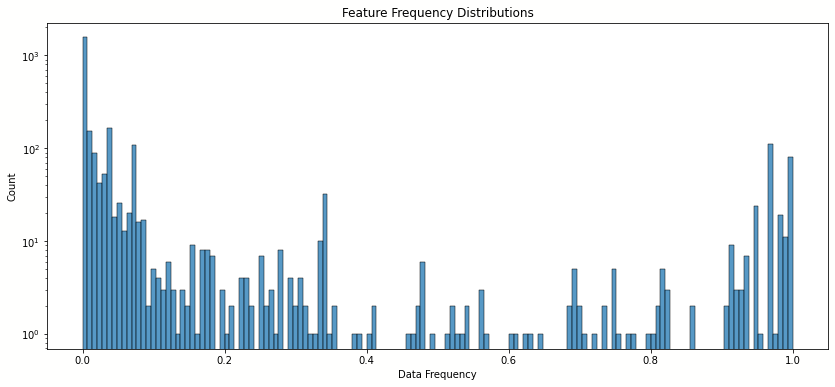

In [140]:
fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fffffe")
sns.histplot(biobank_index_full["frequency"], ax=ax)
ax.set_yscale("log")
add_plt_labels(ax, "Data Frequency", "Count", "Feature Frequency Distributions")
plt.show()
fig.tight_layout()
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("feature_frequency_distribution.png"), facecolor="#fffffe")

# actual EDA

In [141]:
cancer_biobank = biobank_data.loc[~biobank_data["cancer_code"].isna()]

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

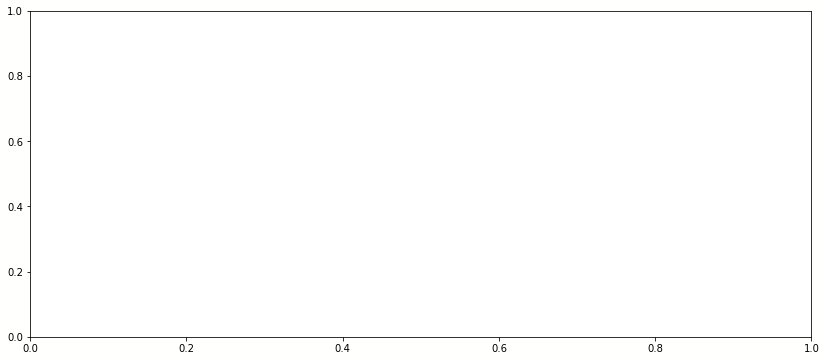

In [142]:
cancer_codes, counts = np.unique(cancer_biobank["cancer_code"], return_counts=True)

common_cancer_codes = cancer_codes[counts > 20]
common_cancer_biobank = cancer_biobank.loc[cancer_biobank["cancer_code"].isin(common_cancer_codes)]


fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fffffe")
sns.kdeplot(data=common_cancer_biobank, x="cancer_dx_age_interpolated", hue="cancer_code", ax=ax, shade=True)
add_plt_labels(ax, "cancer_dx_age_interpolated", "Density")
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("cancer_onset_age.png"), facecolor="#fffffe")

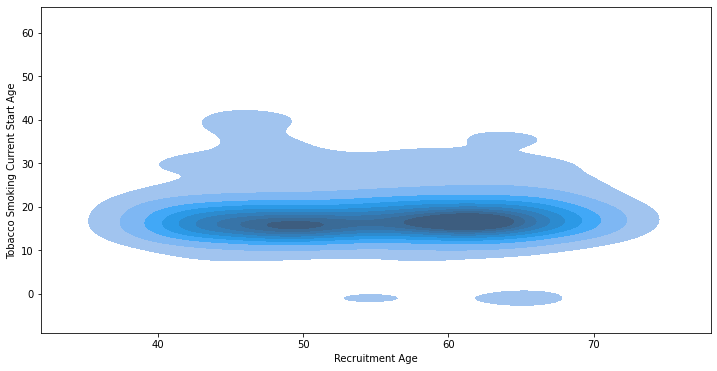

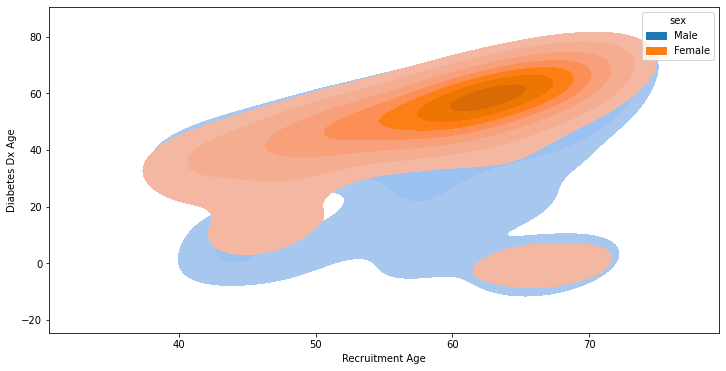

In [86]:
fig, ax = plt.subplots(figsize=(12, 6))
y = "tobacco_smoking_current_start_age"
x = "recruitment_age"

sns.kdeplot(data=biobank_data, y=y, x=x, ax=ax, fill=True)
add_plt_labels(ax, x, y)

y, x = "diabetes_dx_age", "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=biobank_data, x=x, y=y, hue="sex", ax=ax, fill=True)
add_plt_labels(ax, x, y)

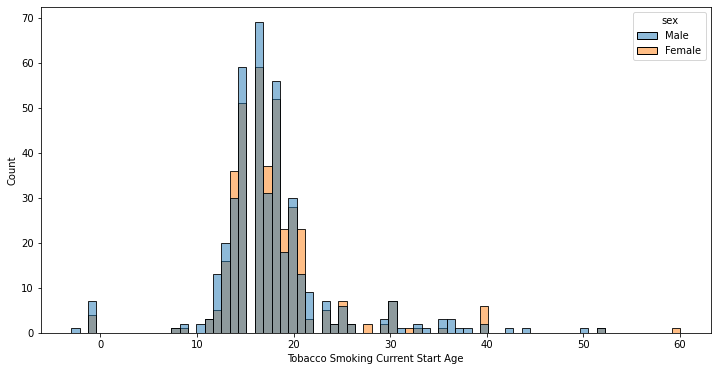

In [89]:
fig, ax = plt.subplots(figsize=(12, 6))
x="tobacco_smoking_current_start_age"
sns.histplot(data=biobank_data, x=x, hue="sex",  ax=ax)
add_plt_labels(ax, x, y="Count")

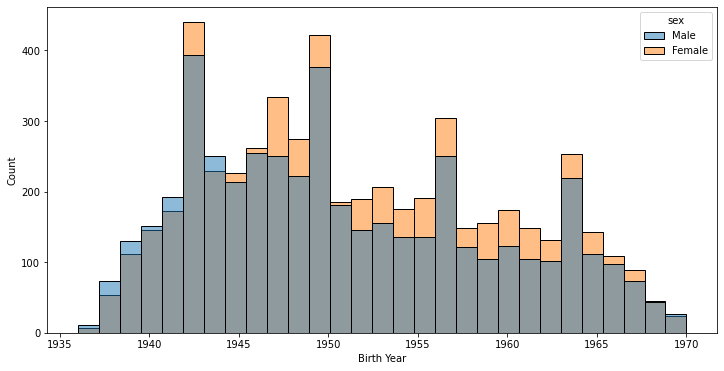

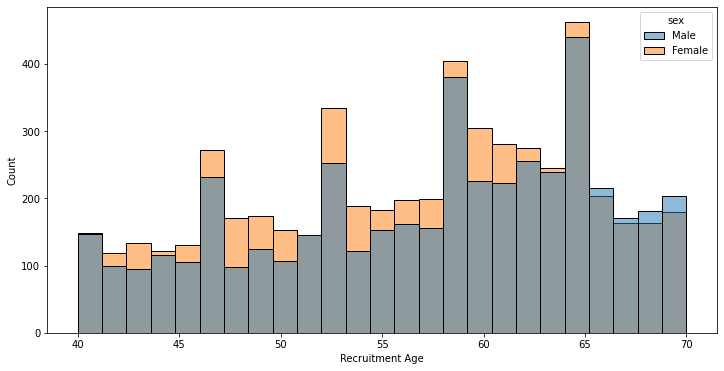

In [90]:
x, hue = "birth_year", "sex"
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=biobank_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")

x = "recruitment_age"
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=biobank_data, x=x, hue=hue, ax=ax)
add_plt_labels(ax, x, y="Count")